In [1]:
##
## UNet 
##
## Взята идея по описанию из https://github.com/pietz/unet-keras
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [6]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, save_model, load_model, Input, Model
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, UpSampling2D
from keras.layers import Conv2D, Concatenate, Reshape
from keras.layers import Activation, Dropout, Flatten, Dense, Permute
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [7]:
keras.__version__

'2.0.4'

In [8]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trDirI = trDirTIF
teDirI = teDirTIF
trWork, teWork = '../Work/Train', '../Work/Test'
trDirI,teDirI, teDirJPG, trWork, teWork

('../Data/train-tif-v2',
 '../Data/test-tif-v2',
 '../Data/test-jpg-v2',
 '../Work/Train',
 '../Work/Test')

In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [14]:
def formImExt (nf, resize=(32,32), printOK=False) :
    nx = None
    try : 
        ni = cv.imread(nf,-1); 
        if (ni is not None) :
            #ni = cv.normalize
            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : print('----- error ---- shape:',ni.shape,nf)
            if (ni.shape[2]==3) :
                nx = cv.resize(ni,resize)
            if (ni.shape[2]==4) :
                #r,g,b,n = ni[:,:,2],ni[:,:,1],ni[:,:,0],ni[:,:,3]
                r,g,b,n = cv.resize(ni[:,:,2],resize),cv.resize(ni[:,:,1],resize),cv.resize(ni[:,:,0],resize),cv.resize(ni[:,:,3],resize)
                dv,dw   = np.divide((r-n),(r+n+0.01)), np.divide((g-n),(g+n+0.01))
                nx      = np.array([r,g,b,n,dv,dw]).T; 
    except BaseException as e :
        print(nf,e); nx = None;
    
    if nx is None and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

In [61]:
trX, trY, i, size = [],[], 0, 10000 #len(nameList)
print(datetime.datetime.now(),len(nameList),size)
for nn in nameList[0:size] :
    #nf = os.path.join(trDirTIF,nn+".tif");
    nf = os.path.join(trDirJPG,nn+".jpg");
    nx = formImExt(nf,resize=(64,64))
    if (nx is not None) :
        #rr=np.save(os.path.join(trWork,nn+".npy"),nx);
        #trX.append(nn+".npy")
        trX.append(nx)
        trY.append(True)
    else : 
        trY.append(False)
    i += 1
    if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)
    #print(nn.shape)

print(datetime.datetime.now())
trX = np.array(trX);
trY = labelList[trY];
print(len(nameList),trX.shape,trY.shape)
#trXY=pd.DataFrame(trY); trXY['name']=trX; trXY.head()
#trXY.to_pickle(os.path.join(trWork,"listFiles.pkl"))

2017-07-04 22:50:11.794476 40479 10000
2017-07-04 22:51:13.956662 	 5000 	 train_4999
2017-07-04 22:52:28.278799 	 10000 	 train_9999
2017-07-04 22:52:28.279944
40479 (10000, 64, 64, 3) (10000, 17)


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 40479 but corresponding boolean dimension is 10000


In [21]:
######np.save('../Data-Keras/Datas/train-model-2D-64x64x6-XX.npy',trX)
######np.save('../Data-Keras/Datas/train-model-2D-64x64x6-YY.npy',trY)
###np.save('../Data-Keras/Datas/train-model-2D-64x64x3-XX.npy',trX)
###np.save('../Data-Keras/Datas/train-model-2D-64x64x3-YY.npy',trY)

In [19]:
#del(trOX); del(trOY);
#del trX,trY

In [15]:
##trXX = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-XX.npy')
##trYY = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-YY.npy')
trXX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-XX.npy')
trYY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-YY.npy')
trX, trY = trXX[trYY[:,3]==0], trYY[trYY[:,3]==0] # not cloudy
del trXX,trYY
print(trX.shape,trY.shape)

(12048, 64, 64, 3) (12048, 17)


In [16]:
#trX=trX/255.0
#trX = cv.normalize(trX, trX, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
#trX=trX/65535.0
#trX[0,:,:]
#trX[:,:,:,5].max(),trX.min(),trX.shape

In [17]:
def fbeta_pred(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    #yy_pred = K.round(y_pred+(0.5-OK1))
    yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    fbeta = (1+beta2)*(precision*recall)/(beta2*precision+recall+eps)
    ##if fbeta>1.0 : fbeta = 1.0;
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return(fbeta)

In [18]:
#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
#
def Kriz2012 ( model, iSize, rSize ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(input_shape=(i1,i2,i3)))
    
    model.add(Convolution2D(96,(11,11),strides=(4,4),activation='relu'))
    model.add(Convolution2D(256,(5,5),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Convolution2D(256,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(4096,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4096,activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

In [19]:
#
# model UNET
#
#    https://github.com/pietz/unet-keras
#
#

def level_block(m, dim, depth, acti):
    if depth > 0:
        
        x = BatchNormalization(axis=3)(m)

        n = Conv2D(dim, (3, 3), activation=acti, padding='same')(x) #(m)
        n = Conv2D(dim, (3, 3), activation=acti, padding='same')(n)
        n = Dropout(0.25)(n) ## add
        m = MaxPooling2D((2, 2))(n)
        m = level_block(m, 2*dim, depth-1, acti)
        m = UpSampling2D((2, 2))(m)
        m = Conv2D(dim, (2, 2), activation=acti, padding='same')(m)
        m = Dropout(0.25)(m) ## add
        m = Concatenate(axis=3)([n, m])
    m = Conv2D(dim, (3, 3), activation=acti, padding='same')(m)
    return Conv2D(dim, (3, 3), activation=acti, padding='same')(m)

def UNet(img_shape, n_out=2, dim=64, depth=4, acti='relu', flatten=False):
    i = Input(shape=img_shape)
    o = level_block(i, dim, depth, acti)
    o = Conv2D(n_out, (1, 1))(o)
    if flatten:
        o = Reshape(n_out, img_shape[0] * img_shape[1])(o)
        o = Permute((2, 1))(o)
    # my insert
    o = Flatten()(o)
    o = Dropout(0.25)(o) ## add
    o = Dense(n_out)(o)
    # -----------------------------
    o = Activation('softmax')(o)
    return Model(inputs=i, outputs=o)


def Kriz2012x3x3 ( model, iSize, rSize, cv2d, dense ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(axis=3,input_shape=(i1,i2,i3)))
    
    if not (cv2d is None) :
        for cv in cv2d :
            if (cv>0) :
                model.add(Convolution2D(cv,(2,2)))
                #model.add(BatchNormalization(axis=3))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2,2)))
                model.add(Dropout(0.25))

    model.add(Flatten())
    
    if not (dense is None) :
        for de in dense :
            if (de>0) :
                model.add(Dense(pp[5],activation='relu'))
                model.add(Dropout(0.5))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

In [116]:
#model = UNet((64,64,3),depth=3,n_out=17)
#model.summary()

In [21]:
def buildModel () :
    model = UNet((64,64,3),depth=4,n_out=17)
    
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
                  optimizer="adam", #sgd, #"adam", #'rmsprop',
                  metrics=['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

In [22]:
model10 = buildModel()

In [29]:
metric = 'acc'
model10.compile(loss= 'binary_crossentropy', 
                #'mean_squared_error', #'mean_absolute_error',  #'binary_crossentropy','categorical_crossentropy',
                  optimizer="rmsprop", #sgd, #"adam", #'rmsprop',
                  metrics=[metric]) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])


In [31]:
#model10.load_weights('../Data-Keras/Models/model-UNet-weights.h5', by_name=False)

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3,min_delta=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

epochs     = 30
verbose    = 2
batch_size = 128 

filepath="../Temp/weights.{epoch:02d}-{val_"+metric+":.4f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')

##model1 = buildModel(iSize,rSize,pp)
tr1    = np.sum([K.count_params(p) for p in set(model10.trainable_weights)])
tr2    = np.sum([K.count_params(p) for p in set(model10.non_trainable_weights)])

#print(tr1,tr2,tr1+tr2)
#assert ((tr1+tr2)>14000000)

step = 1000
low  = 0
high = low+step

print(datetime.datetime.now(),tr1+tr2)
#hist1  = model10.fit(trX[low:high],trY[low:high],
hist1  = model10.fit(trX[low:high],trY[low:high],
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.20, 
                    #callbacks=[early_stopping,reduce_lr,checkpoint],
                    verbose=verbose)

##trP = model1.predict(trX, batch_size=128)
##fbeta2score=fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples')
##fbeta2pred =K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64)))
print(datetime.datetime.now()) #,pp,'fbeta2s=',fbeta2score,fbeta2pred)


2017-07-05 04:53:18.048540 32218350
Train on 800 samples, validate on 200 samples
Epoch 1/30
12s - loss: 2.9805 - acc: 0.8146 - val_loss: 3.0209 - val_acc: 0.8121
Epoch 2/30
12s - loss: 2.9805 - acc: 0.8146 - val_loss: 3.0209 - val_acc: 0.8121
Epoch 3/30
12s - loss: 2.9805 - acc: 0.8146 - val_loss: 3.0209 - val_acc: 0.8121
Epoch 4/30
12s - loss: 2.9805 - acc: 0.8146 - val_loss: 3.0209 - val_acc: 0.8121
Epoch 5/30
12s - loss: 2.9805 - acc: 0.8146 - val_loss: 3.0209 - val_acc: 0.8121
Epoch 6/30
12s - loss: 2.9805 - acc: 0.8146 - val_loss: 3.0209 - val_acc: 0.8121
Epoch 7/30
12s - loss: 2.9805 - acc: 0.8146 - val_loss: 3.0209 - val_acc: 0.8121
Epoch 8/30
12s - loss: 2.9805 - acc: 0.8146 - val_loss: 3.0209 - val_acc: 0.8121
Epoch 9/30
12s - loss: 2.9805 - acc: 0.8146 - val_loss: 3.0209 - val_acc: 0.8121
Epoch 10/30
12s - loss: 2.9805 - acc: 0.8146 - val_loss: 3.0209 - val_acc: 0.8121
Epoch 11/30
12s - loss: 2.9805 - acc: 0.8146 - val_loss: 3.0209 - val_acc: 0.8121
Epoch 12/30
12s - loss: 2

In [ ]:
xx=0

yy=cv.imread(os.path.join(trDirJPG,labels_df.image_name[xx]+'.jpg'),-1)
yy.shape

plt.imshow(yy); plt.show()

plt.imshow(trX[xx]); plt.show()
plt.imshow(trX[xx][:,:,0]); plt.show()
plt.imshow(trX[xx][:,:,1]); plt.show()
plt.imshow(trX[xx][:,:,2]); plt.show()


In [33]:
%time trP = model10.predict(trX, batch_size=128)
trY[0],trP[0]
#trP[:,3]=0

CPU times: user 6.02 s, sys: 1.47 s, total: 7.49 s
Wall time: 48.2 s


(array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.], dtype=float32))

In [34]:
#print(model10.evaluate(trX,trY,verbose=2))
print(trY.shape)
print(trP.shape)
print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64))))

(12048, 17)
(12048, 17)
fbeta_score= 0.173389774236
fbeta_pred = 0.132663262316


In [35]:
fresList=[]

In [36]:
if False :
    save_model(model10,'../Data-Keras/Models/model-UNet.h5')
    model10.save_weights('../Data-Keras/Models/model-UNet-weights.h5')

In [37]:
print(trY.shape)
fres = []
for i in range(trY.shape[1]) :
    if i<>3 :
        cm = skm.confusion_matrix(trY[:,i],trP[:,i])
        tp = len(trP[trP[trY[:,i]==1,i]==1,i])
        tn = len(trP[trP[trY[:,i]==0,i]==0,i])
        fx = len(trP[trP[:,i]<>trY[:,i],i])
        print('{} acc={} roc={} not={} yes={} no={} true={}'.format(i,
              skm.accuracy_score(trY[:,i],trP[:,i]),
              #skm.accuracy_score(trY[:,i],trP[:,i]),
              skm.roc_auc_score(trY[:,i],trP[:,i]),
              cm[0,1]+cm[1,0],
              tp,tn,
              len(trY[trY[:,i]==1,i])
             ))
        fres.append ((i,trY.shape[0],
                skm.accuracy_score(trY[:,i],trP[:,i]),
                #skm.accuracy_score(trY[:,i],trP[:,i]),
                skm.roc_auc_score(trY[:,i],trP[:,i]),
                  cm[0,1]+cm[1,0]))
fresList.append(fres)

(12048, 17)
0 acc=0.776145418327 roc=0.5 not=2697 yes=0 no=9351 true=2697
1 acc=0.182851925631 roc=0.5 not=9845 yes=0 no=2203 true=9845
2 acc=0.737300796813 roc=0.5 not=3165 yes=0 no=8883 true=3165
4 acc=0.841550464807 roc=0.5 not=1909 yes=0 no=10139 true=1909
5 acc=0.952689243028 roc=0.5 not=570 yes=0 no=11478 true=570
6 acc=0.852589641434 roc=0.5 not=1776 yes=0 no=10272 true=1776
7 acc=0.92114873838 roc=0.5 not=950 yes=0 no=11098 true=950


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 2697
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 9351
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 9845
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 2203
/home/boba/anaconda2

8 acc=0.997011952191 roc=0.5 not=36 yes=0 no=12012 true=36
9 acc=0.173389774236 roc=0.5 not=9959 yes=2089 no=0 true=2089
10 acc=0.397327357238 roc=0.5 not=7261 yes=0 no=4787 true=7261
11 acc=0.997509960159 roc=0.5 not=30 yes=0 no=12018 true=30
12 acc=0.990454847278 roc=0.5 not=115 yes=0 no=11933 true=115
13 acc=0.997343957503 roc=0.5 not=32 yes=0 no=12016 true=32
14 acc=0.998256972112 roc=0.5 not=21 yes=0 no=12027 true=21
15 acc=0.997343957503 roc=0.5 not=32 yes=0 no=12016 true=32
16 acc=0.998920982736 roc=0.5 not=13 yes=0 no=12035 true=13


/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 2089
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 9959
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 7261
/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 12048 but corresponding boolean dimension is 4787
/home/boba/anaconda2

In [38]:
cm, trY[trY[:,16]==1],trY[0:16,16],trP[0:16,16]

(array([[12035,     0],
        [   13,     0]]),
 array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.], 

In [39]:
fresList[-1],np.array(fresList)[-1][:,4].sum()

([(0, 12048, 0.77614541832669326, 0.5, 2697),
  (1, 12048, 0.1828519256308101, 0.5, 9845),
  (2, 12048, 0.73730079681274896, 0.5, 3165),
  (4, 12048, 0.84155046480743689, 0.5, 1909),
  (5, 12048, 0.95268924302788849, 0.5, 570),
  (6, 12048, 0.85258964143426297, 0.5, 1776),
  (7, 12048, 0.92114873837981404, 0.5, 950),
  (8, 12048, 0.99701195219123506, 0.5, 36),
  (9, 12048, 0.17338977423638779, 0.5, 9959),
  (10, 12048, 0.39732735723771578, 0.5, 7261),
  (11, 12048, 0.99750996015936255, 0.5, 30),
  (12, 12048, 0.99045484727755639, 0.5, 115),
  (13, 12048, 0.99734395750332006, 0.5, 32),
  (14, 12048, 0.99825697211155373, 0.5, 21),
  (15, 12048, 0.99734395750332006, 0.5, 32),
  (16, 12048, 0.99892098273572372, 0.5, 13)],
 38411.0)

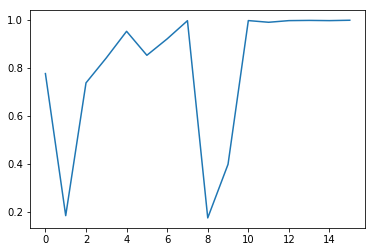

In [40]:
fresList
plt.plot([acc for i,all,acc,roc,nt in fresList[-1]]); 
#plt.plot([acc for i,all,acc,roc,nt in fresList[-2]]); 
plt.show()
#plt.plot([nt for i,all,acc,roc,nt in fresList[-1]]); 
#plt.plot([nt for i,all,acc,roc,nt in fresList[-3]]); 
#plt.show()

In [91]:
trY[0],trP[0]
for i in range(trY.shape[1]) :
    print(i,trY[trY[:,i]==1,:].shape[0])

0 670
1 9272
2 3035
3 6979
4 1824
5 930
6 2005
7 1088
8 51
9 531
10 1820
11 15
12 200
13 88
14 82
15 82
16 33


In [75]:
resAll = resAll+result

In [30]:
model = model1

In [79]:
save_model(model,'../Data-Keras/train-model-2D-2-v2-all.h5')
model.save_weights('../Data-Keras/train-model-2D-2-v2-weights.h5')  # save weights after training

In [31]:
rr, rrx = [], []; trP = model.predict(trX, batch_size=128)
for i in range(trP.shape[1]) :
    xx = [];
    trYY = trY[:,i].astype(np.float64)
    trPY = trP[:,i]
    for ii in range(100) :
        trPP = (trPY>0.01*ii).astype(np.float64)
        #x = fbeta_score(trY[:,0], np.array(trP[:,0] > 0.1*ii), beta=2, average='samples')
        x = K.get_value(fbeta_pred(trYY,trPP))
        xx.append(x)
    rrr = np.array(xx).argmax();
    rr.append(rrr)
    rrx.append(xx[rrr])
    print(datetime.datetime.now(),i,'-->',rrr,xx[rrr],xx[(rrr-1):(rrr+2)])
    #print(xx);
    #plt.plot(np.array(xx)); plt.show()
trM = np.array(rr)/100.0;

2017-05-20 05:22:01.009723 0 --> 70 0.758419290079 [0.75741733368803943, 0.75841929007857778, 0.75785138394714635]
2017-05-20 05:22:23.972821 1 --> 78 0.982638483662 [0.98262473453994426, 0.98263848366246676, 0.98259679666709321]
2017-05-20 05:22:52.632376 2 --> 58 0.847226297632 [0.8469111862002846, 0.84722629763157453, 0.84682213028656683]
2017-05-20 05:23:27.033547 3 --> 78 0.97604678248 [0.97585536488705449, 0.97604678247993626, 0.97586138532621902]
2017-05-20 05:24:07.288213 4 --> 39 0.78729476795 [0.78664609854346335, 0.78729476795032916, 0.78707371492899492]
2017-05-20 05:24:52.980975 5 --> 42 0.789568102568 [0.78871126051941221, 0.78956810256787635, 0.78669767415698355]
2017-05-20 05:25:44.022237 6 --> 47 0.830831644043 [0.8305167161398419, 0.83083164404299403, 0.83015444819651052]
2017-05-20 05:26:40.712293 7 --> 45 0.738016164169 [0.73686966073098015, 0.73801616416924898, 0.73773213859960107]
2017-05-20 05:27:43.679293 8 --> 26 0.676190170231 [0.6690774577597115, 0.6761901702

In [26]:
model.load_weights('../Data-Keras/train-model-2D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [27]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [34]:
#nameAsk = os.listdir(teDirI); print(len(nameAsk))
nameAsk = os.listdir(teDirJPG); print(len(nameAsk))
trOX, trOY, i, ii, size = [], [], 0, 0, len(nameAsk)
print(datetime.datetime.now(),len(nameAsk),size)
for nn in nameAsk[0:size] :
    #nf = os.path.join(teDirTIF,nn);
    nf = os.path.join(teDirJPG,nn);
    nx = formImExt(nf,resize=(64,64))
    if (nx is not None) :
        trOX.append(nx)
        trOY.append(nn)
    i += 1
    if (i%10000==0) and (i>1) :
        if (ii==0) :
            trOX = np.array(trOX); trOX = trOX / 255.0
            trP = model.predict(trOX, batch_size=512); 
        else :
            trOX = np.array(trOX);  trOX = trOX / 255.0
            trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
        trOX,ii = [],ii+1;
    if (i%5000==0) : print(datetime.datetime.now(),"\t",ii,'\t',i,"\t",nn,'\t',(trP.shape if ii>0 else ""))

if (len(trOX)>0) :
    if (ii==0) :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = model.predict(trOX, batch_size=512); 
    else :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
    trOX,ii = [],ii+1;
    
print(datetime.datetime.now())

#assert (size!=len(trOY)), "Wrong files {} != {}".format(size,len(trOY))

61191
2017-05-20 05:46:19.287685 61191 61191
2017-05-20 05:46:38.218814 	 0 	 5000 	 test_14523.jpg 	 
2017-05-20 05:46:51.023731 	 1 	 10000 	 test_19029.jpg 	 (10000, 17)
2017-05-20 05:46:58.884016 	 1 	 15000 	 test_23524.jpg 	 (10000, 17)
2017-05-20 05:47:09.507695 	 2 	 20000 	 test_28015.jpg 	 (20000, 17)
2017-05-20 05:47:16.475888 	 2 	 25000 	 test_32520.jpg 	 (20000, 17)
2017-05-20 05:47:26.837760 	 3 	 30000 	 test_37026.jpg 	 (30000, 17)
2017-05-20 05:47:33.858034 	 3 	 35000 	 test_4908.jpg 	 (30000, 17)
2017-05-20 05:47:44.019579 	 4 	 40000 	 test_9402.jpg 	 (40000, 17)
2017-05-20 05:47:51.298769 	 4 	 45000 	 file_13913.jpg 	 (40000, 17)
2017-05-20 05:48:01.555641 	 5 	 50000 	 file_18419.jpg 	 (50000, 17)
2017-05-20 05:48:24.538867 	 5 	 55000 	 file_4564.jpg 	 (50000, 17)
2017-05-20 05:48:40.785101 	 6 	 60000 	 file_892.jpg 	 (60000, 17)
2017-05-20 05:48:43.863555


In [36]:
#trOX = np.array(trOX);
trOY = np.array([os.path.splitext(x)[0] for x in trOY]);
print(len(nameAsk),trP.shape,trOY.shape)

61191 (61191, 17) (61191,)


In [ ]:
# Saving & Loading

In [26]:
np.save('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy',trOX)
np.save('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy',trOY)

In [27]:
trOX = np.load('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy')
trOY = np.load('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy')
print(trOX.shape,trOY.shape)

(61191, 32, 32, 6) (61191,)


In [37]:
rrx
rrd=dict()
for i in range(len(rrx)) :
    rrd[i]=rrx[i]
rrd

{0: 0.75841929007857778,
 1: 0.98263848366246676,
 2: 0.84722629763157453,
 3: 0.97604678247993626,
 4: 0.78729476795032916,
 5: 0.78956810256787635,
 6: 0.83083164404299403,
 7: 0.73801616416924898,
 8: 0.6761901702314258,
 9: 0.86068787363532673,
 10: 0.96403428373772715,
 11: 0.90053737661152566,
 12: 0.6528441526860862,
 13: 0.86359942524081812,
 14: 0.37037005520335736,
 15: 0.68382329252278806,
 16: 0.58917169677281178}

In [258]:
#Forming result

In [30]:
#trP = model.predict(trOX, batch_size=512); 
trP.shape, trP[-1]

((61191, 17), array([  6.56801313e-02,   7.46541142e-01,   2.32726157e-01,
          9.55386758e-01,   1.95543230e-01,   9.11955476e-01,
          8.89197826e-01,   2.53069662e-02,   1.54045611e-05,
          7.43342913e-04,   6.54759035e-02,   6.17289741e-04,
          8.51887614e-02,   2.95602629e-04,   2.64362683e-07,
          1.03749386e-04,   2.92145728e-07], dtype=float32))

In [38]:
trM=np.array([0.0]*len(labels)); print(trM.shape)
wr = [labels.index(i) for i in weather_labels];
tt=trM; trM[:]=0.5
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

(17,)
[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.5, 0.5, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 2.0, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [39]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trPP = [weather_labels[trP[i,wr].argmax()]] + [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])];
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.   0.5  0.5  2.   0.5  0.5  0.5  0.5  0.5  2.   2.   0.5  0.5  0.5  0.5
  0.5  0.5] [  1.63650557e-01   3.91220033e-01   1.36160061e-01   9.47374701e-01
   9.09343541e-01   1.55211976e-02   3.13203782e-02   1.42206885e-02
   8.06170846e-08   9.10553038e-01   7.85041321e-03   4.12757437e-08
   6.71853591e-03   1.33155788e-06   7.46736941e-06   9.65268737e-06
   7.95199711e-08]


In [40]:
print(labels)
#print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [41]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-05-20-05-51-18
